# This notebook reconstructs buffers to create additional data
Ethnologue data cannot be shared freely due to copyright issues. Therefore you can only view the output of the cells.

# Setup

In [ ]:
import sys, os, time
import matplotlib.pyplot as plt

# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

# GIS packages
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Polygon, Point
import pyproj
import georasters as gr
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

# Various other packages
import isounidecode         # Decode and encode text
import itertools
from functools import reduce

# Paths
proot = '/work/Replication_Dickens_2022/data/'
pathout = proot + 'Ethnologue/'
pathstats = proot + 'stats/'
pathethno = '' # Since the Ethnologed is protected under copy rights we can't upload the dataset.

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/users/ozak/micromamb

In [ ]:
#%%px --local
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [ ]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

# Using Original Data
## Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

Main original replication data file with all pairwise data based on buffers of 50kms

In [ ]:
dfor = pd.read_stata(proot + 'EJ_Dickens_Border_100km.dta')
dforc

/tmp/ipykernel_2493198/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
1,AAA-NGA-OKE-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Okpe,oke,Nigeria,Niger-Congo,0.628569,...,oke,aaa,oke,GHOTUO,OKPE,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
2,AAB-NGA-JID-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Bu,jid,Nigeria,Niger-Congo,0.833333,...,jid,aab,jid,TESU,BU_NIGERIA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
3,AAB-NGA-RIN-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Nungu,rin,Nigeria,Niger-Congo,NaN,...,rin,aab,rin,TESU,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
4,AAB-NGA-TDV-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Toro,tdv,Nigeria,Niger-Congo,0.532142,...,tdv,aab,tdv,TESU,TORO,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,ZYN-CHN-YUE-CHN,"Zhuang, Yongnan",zyn,China,Tai-Kadai,"Chinese, Yue",yue,China,Sino-Tibetan,0.813015,...,yue,zyn,yue,NINGMING_YONGNAN_ZHUANG,CANTONESE,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15599,ZZJ-CHN-CMN-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,"Chinese, Mandarin",cmn,China,Sino-Tibetan,0.865388,...,cmn,zzj,cmn,LONGZHOU_ZHUANG,KUNMING_MANDARIN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15600,ZZJ-CHN-IUM-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Iu Mien,ium,China,Hmong-Mien,0.844456,...,ium,zzj,ium,LONGZHOU_ZHUANG,CHIANGRAI_MIEN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Hmong-Mien,Mienic,Mian-Jin",156.0,156.0,Asia
15601,ZZJ-CHN-TYZ-VNM,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Tay,tyz,Vietnam,Tai-Kadai,0.528902,...,tyz,zzj,tyz,LONGZHOU_ZHUANG,TAY,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central",156.0,704.0,Asia


In [ ]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [ ]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [ ]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa


In [ ]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


## Pairs in original dataset that are the same language but in two countries

In [ ]:
dfor.loc[dfor.identifier.apply(lambda x: x[:3]==x[8:11])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
78,ABR-CIV-ABR-GHA,Abron,abr,Cote d'Ivoire,Niger-Congo,Abron,abr,Ghana,Niger-Congo,NaN,...,abr,abr,abr,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Nyo...","Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Nyo...",384.0,288.0,Africa
164,ADQ-TGO-ADQ-GHA,Adangbe,adq,Togo,Niger-Congo,Adangbe,adq,Ghana,Niger-Congo,NaN,...,adq,adq,adq,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...","Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...",768.0,288.0,Africa
376,AII-TUR-AII-SYR,Assyrian Neo-Aramaic,aii,Turkey,Afro-Asiatic,Assyrian Neo-Aramaic,aii,Syria,Afro-Asiatic,NaN,...,aii,aii,aii,ASSYRIAN_NEO-ARAMAIC,ASSYRIAN_NEO-ARAMAIC,"Afro-Asiatic,Semitic,Central,Aramaic,Eastern,C...","Afro-Asiatic,Semitic,Central,Aramaic,Eastern,C...",792.0,760.0,Asia
407,AJG-TGO-AJG-BEN,Aja,ajg,Togo,Niger-Congo,Aja,ajg,Benin,Niger-Congo,NaN,...,ajg,ajg,ajg,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...","Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...",768.0,204.0,Africa
713,ARS-IRQ-ARS-SAU,"Arabic, Najdi Spoken",ars,Iraq,Afro-Asiatic,"Arabic, Najdi Spoken",ars,Saudi Arabia,Afro-Asiatic,NaN,...,ars,ars,ars,missing,missing,"Afro-Asiatic,Semitic,Central,South,Arabic","Afro-Asiatic,Semitic,Central,South,Arabic",368.0,682.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15002,YBL-CMR-YBL-NGA,Yukuben,ybl,Cameroon,Niger-Congo,Yukuben,ybl,Nigeria,Niger-Congo,NaN,...,ybl,ybl,ybl,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",120.0,566.0,Africa
15112,YKO-GNQ-YKO-CMR,Yasa,yko,Equatorial Guinea,Niger-Congo,Yasa,yko,Cameroon,Niger-Congo,NaN,...,yko,yko,yko,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",226.0,120.0,Africa
15140,YMK-MOZ-YMK-TZA,Maraba,ymk,Mozambique,Niger-Congo,Maraba,ymk,Tanzania,Niger-Congo,NaN,...,ymk,ymk,ymk,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",508.0,834.0,Africa
15159,YOM-AGO-YOM-COD,Yombe,yom,Angola,Niger-Congo,Yombe,yom,Democratic Republic of Congo,Niger-Congo,NaN,...,yom,yom,yom,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",24.0,180.0,Africa


In [ ]:
dfor.loc[dfor.identifier.apply(lambda x: x[:3]==x[8:11]), ['identifier', 'lingDist']]

,identifier,lingDist
78,ABR-CIV-ABR-GHA,NaN
164,ADQ-TGO-ADQ-GHA,NaN
376,AII-TUR-AII-SYR,NaN
407,AJG-TGO-AJG-BEN,NaN
713,ARS-IRQ-ARS-SAU,NaN
...,...,...
15002,YBL-CMR-YBL-NGA,NaN
15112,YKO-GNQ-YKO-CMR,NaN
15140,YMK-MOZ-YMK-TZA,NaN
15159,YOM-AGO-YOM-COD,NaN


# New Data
## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
###  Import data

In [ ]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno['key'] = 0
ethno.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,"116,000,000 in Russian Federation (2002 census)",116000000,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,"215,000,000 in United States (2000 census)",215000000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,"MULTIPOLYGON (((-75.11965 19.97388, -75.11741 ..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,"163,000,000 in Brazil (1998)",163000000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,"17,400,000 in Australia (2006)",17400000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,"MULTIPOLYGON (((147.36099 -43.08758, 147.36375..."
4,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [ ]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [ ]:
ethno.shape

(7327, 19)

## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
Find duplicated languages x country. Unlike v16, v17 has a duplicated language

In [ ]:
ethno.loc[ethno.duplicated('ID')]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry


## Create all pairs of languages/countries

In [ ]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()

import dask.dataframe as dd
from dask.distributed import Client, progress, LocalCluster
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39587 instead
  warnings.warn(


In [ ]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:6876: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [ ]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 66.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:73: UserWarning: Geometry is in a geographic CRS. Res

In [ ]:
pairs.shape

(74396, 38)

In [ ]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [ ]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,CNT_2,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2
427,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,Asia,India,"5,600,000 in India (2007 SIL)",5600000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr


In [ ]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.01)
ethno02 = ddethno.compute()

In [ ]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_1', right_on='ID', suffixes=['', "_1"])
pairs.head()

In [ ]:
pairs['geometry'] = pairs['geometry_1'].values
pairs[['ID_1', 'ID', 'geometry', 'geometry_1']].head()

In [ ]:
pairs = pairs.drop(columns=['ID', 'geometry_1'])

In [ ]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

,ID_1,ID_2,ID,geometry_1,geometry_2
0,RUS-RUS,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
1,JPN-JPN,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((153.81556 24.15803, 153.80374 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
3,CMN-CHN,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((80.58287 38.16474, 80.57683 38...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
4,KHK-MNG,CMN-CHN,CMN-CHN,"POLYGON ((92.34331 48.19710, 92.35761 48.20942...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [ ]:
%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 17.2 µs


(67069, 40)

In [ ]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

,ID_1,ID_2,NAME2_1,NAME2_2
0,RUS-RUS,JPN-JPN,RUSSIAN,JAPANESE
1,RUS-RUS,CMN-CHN,RUSSIAN,"CHINESE, MANDARIN"
2,KHK-MNG,CMN-CHN,"MONGOLIAN, HALH","CHINESE, MANDARIN"
3,MVF-CHN,CMN-CHN,"MONGOLIAN, PERIPHERAL","CHINESE, MANDARIN"
4,KHG-CHN,CMN-CHN,"TIBETAN, KHAMS","CHINESE, MANDARIN"


We have dropped all same pair language/countries, now let's drop all same langauge pairs that are in differenct countries (e.g., SPA-MEX and SPA-GTM). Special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes. It's not clear there is a reason for different ISO code, so we also drop them

(see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

**This differs from Dickens, he seems to keep these**

In [ ]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2
419,SPA-MEX,spa-MEX,spa-mx,spa-MX,Spanish,Spanish,SPANISH,Spanish,Americas,Mexico,...,"4,670,000 in Guatemala (1995)",4670000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Guatemala,spa,SPA-GTM,"MULTIPOLYGON (((-91.24195 15.43928, -91.21367 ..."


In [ ]:
pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
#pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)
pairs.shape

(65681, 40)

In [ ]:
%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 15.5 µs


In [ ]:
non_repeated_pairs

,ID_1,ID_2
0,RUS-RUS,JPN-JPN
1,RUS-RUS,CMN-CHN
2,KHK-MNG,CMN-CHN
3,MVF-CHN,CMN-CHN
4,KHG-CHN,CMN-CHN
...,...,...
35699,SBH-PNG,LIB-PNG
35700,SCV-NGA,GNH-NGA
35701,DJE-BFA,HAU-BFA
35702,BHE-PAK,AEQ-PAK


In [ ]:
#%%timeit
a = pairs.loc[(pairs['ID_1']=='SPA-CHL') & (pairs['ID_2']=='ARN-ARG')].reset_index()
#a = pairs.loc[(pairs['ID_1']=='KHK-MNG') & (pairs['ID_2']=='CMN-CHN')].reset_index()
#a = pairs.loc[(pairs['ID_1']=='RUS-RUS') & (pairs['ID_2']=='JPN-JPN')].reset_index()
a.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1)

0    MULTILINESTRING ((-71.55537903410654 -43.09396...
dtype: object

In [ ]:
%%time
a.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1)

CPU times: user 7.22 ms, sys: 1.36 ms, total: 8.57 ms
Wall time: 6.59 ms


0    MULTILINESTRING ((-71.55537903410654 -43.09396...
dtype: object

In [ ]:
%%time
a.apply(lambda x: x.geometry_1.buffer(0.01).intersection(x.geometry_2.boundary), axis=1)

CPU times: user 23.7 ms, sys: 5.39 ms, total: 29.1 ms
Wall time: 12.5 ms


0    MULTILINESTRING ((-71.54585451036695 -43.09087...
dtype: object

In [ ]:
a.apply(lambda x: x.geometry_1.buffer(0.01).intersection(x.geometry_2.boundary), axis=1)

0    MULTILINESTRING ((-71.54585451036695 -43.09087...
dtype: object

In [ ]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=80)

In [ ]:
%%time
ddpairs['border'] = ddpairs.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1, meta=(None, 'geometry'))
#borders = ddpairs.compute(scheduler="threads", num_workers=120)
borders = ddpairs.compute()

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 15.3 µs


/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 1.60 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
borders[['ID_1', 'ID_2', 'geometry_1', 'geometry_2', 'border']]

,ID_1,ID_2,geometry_1,geometry_2,border
0,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...",MULTILINESTRING ((145.26184710393858 43.613034...
1,RUS-RUS,CMN-CHN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",MULTILINESTRING ((118.04027338250799 49.386957...
2,KHK-MNG,CMN-CHN,"POLYGON ((92.34331 48.19710, 92.35761 48.20942...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",LINESTRING (96.2969147770595 42.52898063260273...
3,MVF-CHN,CMN-CHN,"POLYGON ((97.30358 41.93900, 97.29472 41.94927...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",MULTILINESTRING ((97.17575743470472 42.7728038...
4,KHG-CHN,CMN-CHN,"POLYGON ((86.24880 31.02358, 86.25015 31.02981...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",LINESTRING (102.24263019084742 29.725476550719...
...,...,...,...,...,...
65676,HAU-BFA,DJE-BFA,"MULTIPOLYGON (((1.54296 11.82437, 1.54271 11.8...","MULTIPOLYGON (((1.58616 12.54497, 1.58497 12.5...",LINESTRING (1.913310000000024 11.5942549999999...
65677,BHE-PAK,AEQ-PAK,"POLYGON ((69.46580 25.47820, 69.46580 25.47827...","POLYGON ((69.54476 25.17083, 69.54605 25.17116...",LINESTRING (69.54476271484373 25.1708347050781...
65678,AEQ-PAK,BHE-PAK,"POLYGON ((69.40962 25.31827, 69.42491 25.33095...","POLYGON ((69.48241 25.27896, 69.48404 25.27909...",LINESTRING (69.48240614843752 25.2789589296875...
65679,XNB-TWN,SXR-TWN,"POLYGON ((120.87169 23.52521, 120.88809 23.525...","POLYGON ((120.71130 23.26549, 120.71258 23.264...",LINESTRING (120.71130100000005 23.265488000000...


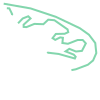

In [ ]:
borders.loc[0, 'border']

In [ ]:
borders_geo = gp.GeoDataFrame(borders, crs=ethno.crs, geometry='border')
borders_geo.head()

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2,border
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,121000000,Japonic,L,Japonic,JAPONIC,Japan,jpn,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...","MULTILINESTRING ((145.26185 43.61303, 145.2890..."
1,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...","MULTILINESTRING ((118.04027 49.38696, 118.0152..."
2,KHK-MNG,khk-MNG,khk-mn,khk-MG,Halh Mongolian,"Mongolian, Halh","MONGOLIAN, HALH","Mongolian, Halh",Asia,Mongolia,...,840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...","LINESTRING (96.29691 42.52898, 96.30858 42.544..."
3,MVF-CHN,mvf-CHN,mvf-cn,mvf-CH,Peripheral Mongolian,"Mongolian, Peripheral","MONGOLIAN, PERIPHERAL","Mongolian, Peripheral",Asia,China,...,840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...","MULTILINESTRING ((97.17576 42.77280, 97.20853 ..."
4,KHG-CHN,khg-CHN,khg-cn,khg-CH,Khams Tibetan,"Tibetan, Khams","TIBETAN, KHAMS","Tibetan, Khams",Asia,China,...,840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...","LINESTRING (102.24263 29.72548, 102.20450 29.7..."


In [ ]:
borders_geo[borders_geo.columns.difference(['geometry_1', 'geometry_2'])].to_file(pathout + 'ethnologue_bordersv16.json', driver="GeoJSON")
#borders_geo.to_csv(pathout + 'ethnologue_bordersv16.csv', encoding='utf8', index=False)

## Overlap Datasets

Let's see overlap between both datasets and ways to merge

Create alternative IDs since we do not know order

In [ ]:
borders_geo['identifier'] = borders_geo['ID_1'] + '-' + borders_geo['ID_2']
borders_geo['identifier']

0        RUS-RUS-JPN-JPN
1        RUS-RUS-CMN-CHN
2        KHK-MNG-CMN-CHN
3        MVF-CHN-CMN-CHN
4        KHG-CHN-CMN-CHN
              ...       
65676    HAU-BFA-DJE-BFA
65677    BHE-PAK-AEQ-PAK
65678    AEQ-PAK-BHE-PAK
65679    XNB-TWN-SXR-TWN
65680    SXR-TWN-XNB-TWN
Name: identifier, Length: 65681, dtype: object

In [ ]:
dfor['ID_1'] = dfor['identifier'].apply(lambda x: x[:7])
dfor['ID_2'] = dfor['identifier'].apply(lambda x: x[8:])
dfor['ID_1alt'] = dfor['ID_2']
dfor['ID_2alt'] = dfor['ID_1']
dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']]

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
15598,ZYN-CHN,YUE-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
15599,ZZJ-CHN,CMN-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
15600,ZZJ-CHN,IUM-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
15601,ZZJ-CHN,TYZ-VNM,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


We check for non-repeated language-country pairs in original data

In [ ]:
dfor.loc[dfor.duplicated('identifier')]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


In [ ]:
dfor.loc[dfor.duplicated(subset=['ID_1', 'ID_2'])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


In [ ]:
dfor.loc[dfor.duplicated(subset=['ID_1', 'ID_2'])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


## Merge

In [ ]:
merge_iden = dfor[['identifier']].merge(borders_geo[['ID_1', 'ID_2', 'identifier']])
merge_iden

,identifier,ID_1,ID_2
0,AAA-NGA-EMA-NGA,AAA-NGA,EMA-NGA
1,AAA-NGA-OKE-NGA,AAA-NGA,OKE-NGA
2,AAB-NGA-JID-NGA,AAB-NGA,JID-NGA
3,AAB-NGA-RIN-NGA,AAB-NGA,RIN-NGA
4,AAB-NGA-TDV-NGA,AAB-NGA,TDV-NGA
...,...,...,...
15516,ZYN-CHN-YUE-CHN,ZYN-CHN,YUE-CHN
15517,ZZJ-CHN-CMN-CHN,ZZJ-CHN,CMN-CHN
15518,ZZJ-CHN-IUM-CHN,ZZJ-CHN,IUM-CHN
15519,ZZJ-CHN-TYZ-VNM,ZZJ-CHN,TYZ-VNM


In [ ]:
merge1 = dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']])
merge1alt = dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], 
                                                             left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])
merged1 = pd.concat([merge1, merge1alt]).reset_index(drop=True)
merged1

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
31037,YUE-CHN,ZYN-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
31038,CMN-CHN,ZZJ-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
31039,IUM-CHN,ZZJ-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
31040,TYZ-VNM,ZZJ-CHN,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [ ]:
merged1.loc[merged1.duplicated(subset=['identifier'])]

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
15521,EMA-NGA,AAA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
15522,OKE-NGA,AAA-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
15523,JID-NGA,AAB-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
15524,RIN-NGA,AAB-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
15525,TDV-NGA,AAB-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
31037,YUE-CHN,ZYN-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
31038,CMN-CHN,ZZJ-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
31039,IUM-CHN,ZZJ-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
31040,TYZ-VNM,ZZJ-CHN,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [ ]:
dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], how='left')

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
15598,ZYN-CHN,YUE-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
15599,ZZJ-CHN,CMN-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
15600,ZZJ-CHN,IUM-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
15601,ZZJ-CHN,TYZ-VNM,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [ ]:
dfor[['ID_1', 'ID_2', 'identifier']].merge(non_repeated_pairs[['ID_1', 'ID_2']])

,ID_1,ID_2,identifier
0,AAL-CMR,MXF-CMR,AAL-CMR-MXF-CMR
1,AAR-ETH,AMH-ETH,AAR-ETH-AMH-ETH
2,AAR-ETH,GAX-ETH,AAR-ETH-GAX-ETH
3,AAR-ETH,SOM-ETH,AAR-ETH-SOM-ETH
4,AAW-PNG,LMG-PNG,AAW-PNG-LMG-PNG
...,...,...,...
2589,ZYB-CHN,ZYN-CHN,ZYB-CHN-ZYN-CHN
2590,ZYB-CHN,ZZJ-CHN,ZYB-CHN-ZZJ-CHN
2591,ZYJ-CHN,ZGN-CHN,ZYJ-CHN-ZGN-CHN
2592,ZYJ-CHN,ZZJ-CHN,ZYJ-CHN-ZZJ-CHN


In [ ]:
dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])

,ID_1alt,ID_2alt,identifier,ID_1,ID_2
0,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA,EMA-NGA,AAA-NGA
1,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA,OKE-NGA,AAA-NGA
2,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA,JID-NGA,AAB-NGA
3,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA,RIN-NGA,AAB-NGA
4,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA,TDV-NGA,AAB-NGA
...,...,...,...,...,...
15516,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN,YUE-CHN,ZYN-CHN
15517,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN,CMN-CHN,ZZJ-CHN
15518,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN,IUM-CHN,ZZJ-CHN
15519,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM,TYZ-VNM,ZZJ-CHN


In [ ]:
dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(non_repeated_pairs[['ID_1', 'ID_2']], left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])

,ID_1alt,ID_2alt,identifier,ID_1,ID_2
0,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA,EMA-NGA,AAA-NGA
1,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA,OKE-NGA,AAA-NGA
2,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA,JID-NGA,AAB-NGA
3,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA,RIN-NGA,AAB-NGA
4,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA,TDV-NGA,AAB-NGA
...,...,...,...,...,...
14274,TYZ-VNM,ZYN-CHN,ZYN-CHN-TYZ-VNM,TYZ-VNM,ZYN-CHN
14275,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN,YUE-CHN,ZYN-CHN
14276,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN,CMN-CHN,ZZJ-CHN
14277,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN,IUM-CHN,ZZJ-CHN


In [ ]:
%%time
non_repeated_pairs_or = drop_repeated(dfor[['ID_1', 'ID_2', 'identifier']], ['ID_1', 'ID_2'])
non_repeated_pairs_or

CPU times: user 4.61 s, sys: 51.8 ms, total: 4.66 s
Wall time: 4.57 s


,ID_1,ID_2
0,AAA-NGA,EMA-NGA
1,AAA-NGA,OKE-NGA
2,AAB-NGA,JID-NGA
3,AAB-NGA,RIN-NGA
4,AAB-NGA,TDV-NGA
...,...,...
15598,ZYN-CHN,YUE-CHN
15599,ZZJ-CHN,CMN-CHN
15600,ZZJ-CHN,IUM-CHN
15601,ZZJ-CHN,TYZ-VNM


## Identify missing indentifiers

In [ ]:
missing_or = list(set(borders_geo.identifier).difference(dfor.identifier))
len(missing_or)

50160

In [ ]:
borders_geo.shape[0] - merge_iden.shape[0]

50160

In [ ]:
missing = list(set(dfor.identifier).difference(borders_geo.identifier))
len(missing)

82

In [ ]:
missing[0]

'GUW-BEN-GUW-NGA'

In [ ]:
pairs.loc[pairs.ID_1==missing[0][:7], ['ID_1', 'ID_2']]

,ID_1,ID_2
37420,GUW-BEN,YOR-NGA
37960,GUW-BEN,FON-BEN
38203,GUW-BEN,AYB-BEN
38206,GUW-BEN,NQG-BEN
39021,GUW-BEN,WEM-BEN
39157,GUW-BEN,XWL-BEN
39340,GUW-BEN,TFI-BEN
39660,GUW-BEN,GBX-BEN
40174,GUW-BEN,GBH-BEN


In [ ]:
ethno.loc[ethno.ID==missing[0][:7]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
4239,GUW-BEN,guw-BEN,guw-bj,guw-BN,Gun,Gun,GUN,Gun,Africa,Benin,"320,000 in Benin (2006)",320000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Kwa,...",L,Niger-Congo,NIGER-CONGO,Benin,guw,"POLYGON ((2.75274 6.57108, 2.75312 6.57047, 2...."


<AxesSubplot:>

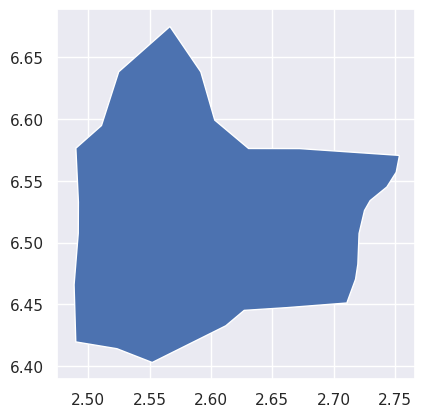

In [ ]:
ethno.loc[ethno.ID==missing[0][:7]].plot()

True
True


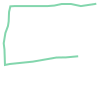

In [ ]:
A = ethno.loc[ethno.ID==missing[0][:7], 'geometry'].values[0]
B = ethno.loc[ethno.ID==missing[0][8:], 'geometry'].values[0]
print(A.intersects(B))
print(A.buffer(0.2).intersects(B))
A.buffer(0.2).intersection(B.boundary)

In [ ]:
ethno.loc[ethno.ID==missing[0][8:]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
3804,GUW-NGA,guw-NGA,guw-ng,guw-NI,Gun,Gun,GUN,Gun,Africa,Nigeria,"259,000 in Nigeria (2000)",259000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Kwa,...",L,Niger-Congo,NIGER-CONGO,Nigeria,guw,"POLYGON ((3.10732 6.53661, 3.11691 6.51627, 3...."


<AxesSubplot:>

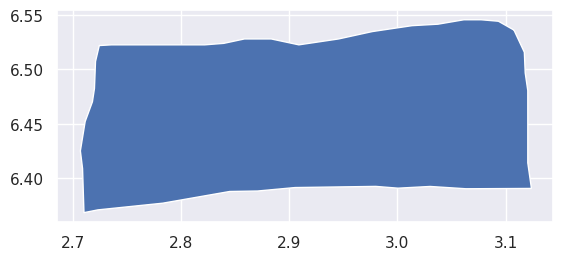

In [ ]:
ethno.loc[ethno.ID==missing[0][8:]].plot()

<AxesSubplot:>

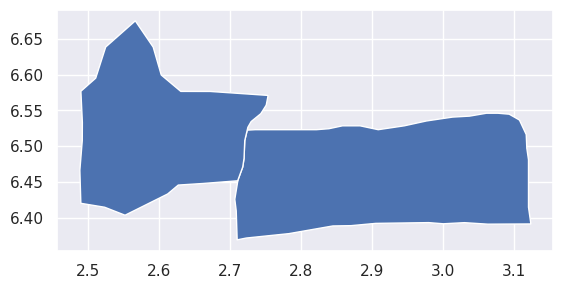

In [ ]:
ethno.loc[(ethno.ID==missing[0][:7])|(ethno.ID==missing[0][8:])].plot()

In [ ]:
pairs.loc[(pairs.ID_1==missing[0][:7])&(pairs.ID_2==missing[0][8:])]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2


In [ ]:
pairs.loc[(pairs.ID_2==missing[0][:7])&(pairs.ID_1==missing[0][8:])]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2


These are missing because they are the same language but in two countries

In [ ]:
same_lang_miss = []
diff_lang_miss = []
for m in missing:
    if m[:3]==m[8:11]:
        same_lang_miss.append(m)
    else:
        diff_lang_miss.append(m)

In [ ]:
len(diff_lang_miss)

1

In [ ]:
diff_lang_miss

['MVE-PAK-RWR-IND']

This is the language we dropped above since it is the same language

In [ ]:
for m in diff_lang_miss:
    print(pairs.loc[(pairs.ID_2==m[:7])&(pairs.ID_1==m[8:])])
    A = ethno.loc[ethno.ID==m[:7], 'geometry'].values[0]
    B = ethno.loc[ethno.ID==m[8:], 'geometry'].values[0]
    print(A.intersects(B))
    print(A.buffer(0.01).intersects(B))
    A.buffer(0.01).intersection(B.boundary)

Empty DataFrame
Columns: [ID_1, ID_ISO_A3_1, ID_ISO_A2_1, ID_FIPS_1, NAM_LABEL_1, NAME_PROP_1, NAME2_1, NAM_ANSI_1, CNT_1, C1_1, POP_1, LMP_POP1_1, G_1, LMP_CLASS_1, FAMILYPROP_1, FAMILY_1, LMP_C1_1, LANG_ISO_1, geometry_1, index_2, ID_2, ID_ISO_A3_2, ID_ISO_A2_2, ID_FIPS_2, NAM_LABEL_2, NAME_PROP_2, NAME2_2, NAM_ANSI_2, CNT_2, C1_2, POP_2, LMP_POP1_2, G_2, LMP_CLASS_2, FAMILYPROP_2, FAMILY_2, LMP_C1_2, LANG_ISO_2, ID, geometry_2]
Index: []

[0 rows x 40 columns]
True
True


True
True


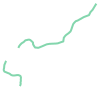

In [ ]:
#m = 'MVE-PAK-RWR-IND'
A = ethno.loc[ethno.ID==m[:7], 'geometry'].values[0]
B = ethno.loc[ethno.ID==m[8:], 'geometry'].values[0]
print(A.intersects(B))
print(A.buffer(0.01).intersects(B))
A.buffer(0.01).intersection(B.boundary)

In [ ]:
gp.sjoin(ethno.loc[ethno.ID==m[:7]], ethno.loc[ethno.ID==m[8:]])

,ID_left,ID_ISO_A3_left,ID_ISO_A2_left,ID_FIPS_left,NAM_LABEL_left,NAME_PROP_left,NAME2_left,NAM_ANSI_left,CNT_left,C1_left,...,CNT_right,C1_right,POP_right,LMP_POP1_right,G_right,LMP_CLASS_right,FAMILYPROP_right,FAMILY_right,LMP_C1_right,LANG_ISO_right
427,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,Asia,India,"5,600,000 in India (2007 SIL)",5600000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr


In [ ]:
ethno.loc[ethno.ID==m[:7]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
427,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,"220,000",220000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,Pakistan,mve,"MULTIPOLYGON (((72.62295 28.88861, 72.61978 28..."


In [ ]:
ethno.loc[ethno.ID==m[8:]]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
70,RWR-IND,rwr-IND,rwr-in,rwr-IN,Marwari,Marwari,MARWARI,Marwari,Asia,India,"5,600,000 in India (2007 SIL)",5600000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr,"POLYGON ((74.37386 28.88966, 74.44544 28.86189..."


In [ ]:
missing_lang = []
for m in missing:
    a = ethno.loc[ethno.ID==m[:7]]
    b = ethno.loc[ethno.ID==m[8:]]
    if a.shape[0]==0:
        missing_lang.append(m[:7])
    if b.shape[0]==0:
        missing_lang.append(m[8:])
missing_lang = list(set(missing_lang))
missing_lang

[]

In [ ]:
missing_pairs_or = []
for m in missing:
    a = dfor.loc[dfor.identifier==m]
    if a.shape[0]==0:
        missing_pairs_or.append(m[:7])
missing_pairs_or = list(set(missing_pairs_or))
missing_pairs_or

[]

In [ ]:
ethno.shape

(7327, 19)

In [ ]:
dfor.shape[0] - len(same_lang_miss) - 1

15521

In [ ]:
merge_iden.shape

(15521, 3)

We have (essencially) replicated his data

# New Data - Buffers

In [ ]:
buffers= borders_geo[['identifier', 'border']].merge(merge_iden[['identifier']])
buffers

,identifier,border
0,KHK-MNG-CMN-CHN,"LINESTRING (96.29691 42.52898, 96.30858 42.544..."
1,KHG-CHN-CMN-CHN,"LINESTRING (102.24263 29.72548, 102.20450 29.7..."
2,ADX-CHN-CMN-CHN,"MULTILINESTRING ((103.34328 32.41462, 103.3294..."
3,XAL-CHN-CMN-CHN,"MULTILINESTRING ((101.03075 36.42174, 101.0269..."
4,KAZ-CHN-CMN-CHN,"MULTILINESTRING ((85.79039 43.12162, 85.78670 ..."
...,...,...
15516,TRB-PNG-KBW-PNG,"MULTILINESTRING ((143.91458 -3.71256, 143.8948..."
15517,JAS-NCL-BIS-NCL,"LINESTRING (166.46485 -22.28114, 166.45645 -22..."
15518,ATW-USA-NMU-USA,"LINESTRING (-120.67960 40.41202, -120.65526 40..."
15519,BDX-IDN-TOY-IDN,"LINESTRING (119.31693 -2.07812, 119.30790 -2.0..."


In [ ]:
buffers.to_file(pathout + 'Dickens_ethnologue_bordersv16.json', driver="GeoJSON")

We convert to CEA to construct the buffers and create the data

In [ ]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_bordersv16.json', driver="GeoJSON")

In [ ]:
buffers = buffers.to_crs(cea)

In [ ]:
buffers.loc[buffers.identifier.isin(dfor.loc[(dfor.overlap==1)&(dfor.lingDist.isna()==False), 'identifier'])]

,identifier,geometry
0,KHK-MNG-CMN-CHN,"LINESTRING (10719723.518 4291279.974, 10721022..."
1,KHG-CHN-CMN-CHN,"LINESTRING (11381597.530 3144847.052, 11377352..."
2,ADX-CHN-CMN-CHN,"MULTILINESTRING ((11504121.326 3400425.288, 11..."
3,XAL-CHN-CMN-CHN,"MULTILINESTRING ((11246691.544 3767434.038, 11..."
4,KAZ-CHN-CMN-CHN,"MULTILINESTRING ((9550142.527 4339640.290, 954..."
...,...,...
15224,SPI-IDN-WRP-IDN,"MULTILINESTRING ((15198378.500 -243002.697, 15..."
15277,NFK-NGA-NIN-NGA,"MULTILINESTRING ((946192.295 1014271.323, 9477..."
15278,NFG-NGA-NIN-NGA,"MULTILINESTRING ((946192.295 1014271.323, 9477..."
15351,DTI-MLI-DYM-MLI,"LINESTRING (-358800.975 1596475.771, -358305.1..."


In [ ]:
buffers.to_file(pathout + 'Dickens_ethnologue_bordersv16_cyl.json', driver="GeoJSON")

In [ ]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_bordersv16_cyl.json', driver="GeoJSON")

In [ ]:
buffers = dask_geopandas.from_geopandas(buffers, npartitions=50)

In [ ]:
buffers.shape

(Delayed('int-56961140-1170-4645-8da9-9e6a8b9ba991'), 2)

In [ ]:
buffers.geometry = buffers.geometry.buffer(50000)
buffers = buffers.compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 18.64 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
buffers.to_file(pathout + 'Dickens_ethnologue_buffersv16_cyl.json', driver="GeoJSON")

In [ ]:
buffers = buffers.to_crs(wgs84)

In [ ]:
buffers.to_file(pathout + 'Dickens_ethnologue_buffersv16.json', driver="GeoJSON")

/tmp/ipykernel_3327376/2640991670.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers.centroid.plot()


<AxesSubplot:>

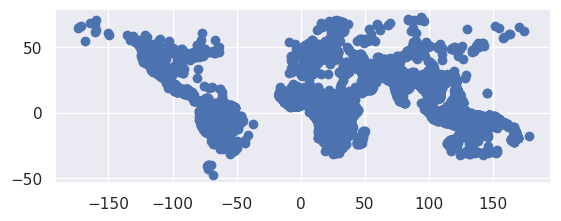

In [ ]:
buffers.centroid.plot()

In [ ]:
type(buffers)

geopandas.geodataframe.GeoDataFrame

# New Data - Spatial Stats for New Buffers

In [ ]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_buffersv16.json', driver="GeoJSON")
buffers.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

BZX-MLI is contained inside the homeland of FFM-MLI and is only 290m^2 so we also drop it. Construction identifies it by assigning empty border

In [ ]:
dfor.loc[dfor.identifier=='BZX-MLI-FFM-MLI']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt
2571,BZX-MLI-FFM-MLI,"Bozo, Hainyaxo",bzx,Mali,Niger-Congo,"Fulfulde, Maasina",ffm,Mali,Niger-Congo,0.869855,...,FULFULDE_MAASINA,"Niger-Congo,Mande,Western,Northwestern,Soninke...","Niger-Congo,Atlantic-Congo,Atlantic,Northern,S...",466.0,466.0,Africa,BZX-MLI,FFM-MLI,FFM-MLI,BZX-MLI


In [ ]:
buffers.loc[buffers.is_valid==False]

,identifier,geometry
673,XMW-MDG-PLT-MDG,"POLYGON ((47.46021 -15.86305, 47.53486 -15.769..."
8140,BZX-MLI-FFM-MLI,None


In [ ]:
buffers = buffers.loc[buffers.identifier!='BZX-MLI-FFM-MLI'].reset_index(drop=True)

Work with CSI data to compute spatial statistics

In [ ]:
CSI = os.listdir(proot + 'CSI')

In [ ]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [ ]:
%%time
for r in CSI:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSI/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[1:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier'] + [r.replace('.tif', '') + c for c in out.columns[1:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_' + r.replace('.tif', '') + '.dta', version=117, write_index=False)    

dif2AverageCalories
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
dif2AverageCalories0
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
dif2AverageCaloriesNo0
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
dif2OptCalories
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
dif2OptCalories0
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
dif2OptCaloriesNo0
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
difAverageCalories
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
difAverageCalories0
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
difAverageCaloriesNo0
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
difOptCalories
Index(['identifier', 'std', 'min', 'median', 'mean', 'max'], dtype='object')
difOptCalories0
Index(['identifier', '

In [ ]:
%%time
out = []
for r in CSI:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_' + r.replace('.tif', '') + '.dta')   
    out1 = out1.set_index(['identifier'])
    out.append(out1)

dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCaloriesNo0
pre15002AverageCalories
pre15002AverageCalories0
pre15002AverageCaloriesNo0
pre15002OptCalories
pre15002OptCalories0
pre15002OptCaloriesNo0
pre1500AverageCalories
pre1500AverageCalories0
pre1500AverageCaloriesNo0
pre1500OptCalories
pre1500OptCalories0
pre1500OptCaloriesNo0
CPU times: user 1.09 s, sys: 480 ms, total: 1.57 s
Wall time: 1.39 s


In [ ]:
out = pd.concat(out, axis=1)

In [ ]:
out.to_stata(proot + 'Dickens_OrBuf_v16_stats.dta', version=117)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4a945f27-2c4c-4244-8f3b-ab6dff812a2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>